# Music Box Churn Prediction and Recommendation using Spark

# Using Spark to generate features

## 1. Load data into Spark dataframe

In [1]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# sc = SparkContext('local')
# spark = SparkSession(sc)
spark = SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.csv('data/events.csv', header=True).cache()
df # Show column names and types of dataframe

DataFrame[uid: string, event: string, song_id: string, date: string]

In [4]:
df.show() # default show 20

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168408359|    P| 5638883|2017-04-10|
|168261396|    P| 5841437|2017-04-10|
|168478408|    P|23534985|2017-04-10|
|168064721|    P|  853270|2017-04-10|
|168411174|    P|23562956|2017-04-10|
|168503909|    P|  294786|2017-04-10|
|168066213|    P| 6329735|2017-04-10|
|168483420|    P|       0|2017-04-10|
|168064721|    P|  853270|2017-04-10|
|168374657|    P|20674550|2017-04-10|
|168408359|    P| 5638883|2017-04-10|
|168282577|    P|  466825|2017-04-10|
|168156044|    P| 3373247|2017-04-10|
|168074544|    P| 3194407|2017-04-10|
|168441911|    P| 1168171|2017-04-10|
|168523596|    P| 8339943|2017-04-10|
|168479778|    P| 6983870|2017-04-10|
|168412268|    P|22807949|2017-04-10|
|168427662|    P|       0|2017-04-10|
|168427662|    P|       0|2017-04-10|
+---------+-----+--------+----------+
only showing top 20 rows



#### Convert type of date column from `string` to `date`

In [5]:
df = df.withColumn('date', F.col('date').cast('date'))
df # notice the type of date column is date now

DataFrame[uid: string, event: string, song_id: string, date: date]

In [6]:
df.show(5)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168408359|    P| 5638883|2017-04-10|
|168261396|    P| 5841437|2017-04-10|
|168478408|    P|23534985|2017-04-10|
|168064721|    P|  853270|2017-04-10|
|168411174|    P|23562956|2017-04-10|
+---------+-----+--------+----------+
only showing top 5 rows



## 2. Exploratory data analysis

#### Count number of rows

```SQL
SELECT COUNT(*)
FROM event_ds_table;
```

In [7]:
df.count()

11264316

There are 11,264,316 rows in the table

#### Count distinct `uid`

```SQL
SELECT COUNT(DISTINCT(uid))
FROM event_ds_table;
```

In [8]:
df.select('uid').distinct().count()

51637

There are 51,637 users.

#### Group by

```SQL
SELECT COUNT(*)
FROM events_ds_table
GROUP BY event;
```

In [9]:
df.groupBy('event').count().show()

+-----+-------+
|event|  count|
+-----+-------+
|    D| 612522|
|    S| 763393|
|    P|9888401|
+-----+-------+



```SQL
SELECT COUNT(uid) as count, MAX(uid) as max_uid
FROM event_ds_table
GROUP BY event;
```

In [10]:
df.groupBy('event').agg(
    F.count(F.col('uid')).alias('count'),
    F.max(F.col('uid')).alias('max_uid')
).show()

+-----+-------+--------+
|event|  count| max_uid|
+-----+-------+--------+
|    D| 612522|98585831|
|    S| 763393| 9920471|
|    P|9888401|99693228|
+-----+-------+--------+



#### Filter
```SQL
SELECT date, event, count(*)
FROM event_ds_table
WHERE date > '2017-04-01' AND date < '2017-04-10'
GROUP BY date, event
ORDER BY date, event
```

In [11]:
df.filter((F.col('date') > '2017-04-01') & 
          (F.col('date') <= '2017-04-10')).groupBy('date', 'event').count().orderBy('date', 'event').show()

+----------+-----+------+
|      date|event| count|
+----------+-----+------+
|2017-04-02|    D| 28397|
|2017-04-02|    P|442483|
|2017-04-02|    S| 30086|
|2017-04-03|    D| 21732|
|2017-04-03|    P|238498|
|2017-04-03|    S| 26299|
|2017-04-04|    D| 22707|
|2017-04-04|    P|284815|
|2017-04-04|    S| 24693|
|2017-04-05|    D| 16106|
|2017-04-05|    P|176670|
|2017-04-05|    S| 20809|
|2017-04-06|    D| 18049|
|2017-04-06|    P|318029|
|2017-04-06|    S| 18675|
|2017-04-07|    D| 13391|
|2017-04-07|    P|231559|
|2017-04-07|    S| 19556|
|2017-04-08|    D| 12856|
|2017-04-08|    P|297027|
+----------+-----+------+
only showing top 20 rows



#### Export to pandas

In [12]:
date_count = df.groupBy('date').count().toPandas()

In [13]:
date_count.head()

,date,count
0,2017-04-09,326307
1,2017-05-11,189493
2,2017-04-25,225419
3,2017-04-03,286529
4,2017-04-29,227418


In [14]:
date_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
date     44 non-null object
count    44 non-null int64
dtypes: int64(1), object(1)
memory usage: 784.0+ bytes


In [15]:
date_count['date'].max()

datetime.date(2017, 5, 12)

In [16]:
date_count['date'].min()

datetime.date(2017, 3, 30)

Because I use `.groupBy('date')`, there are 44 days between 2017/3/30 to 2017/5/12. Therefore, the entries are 44.

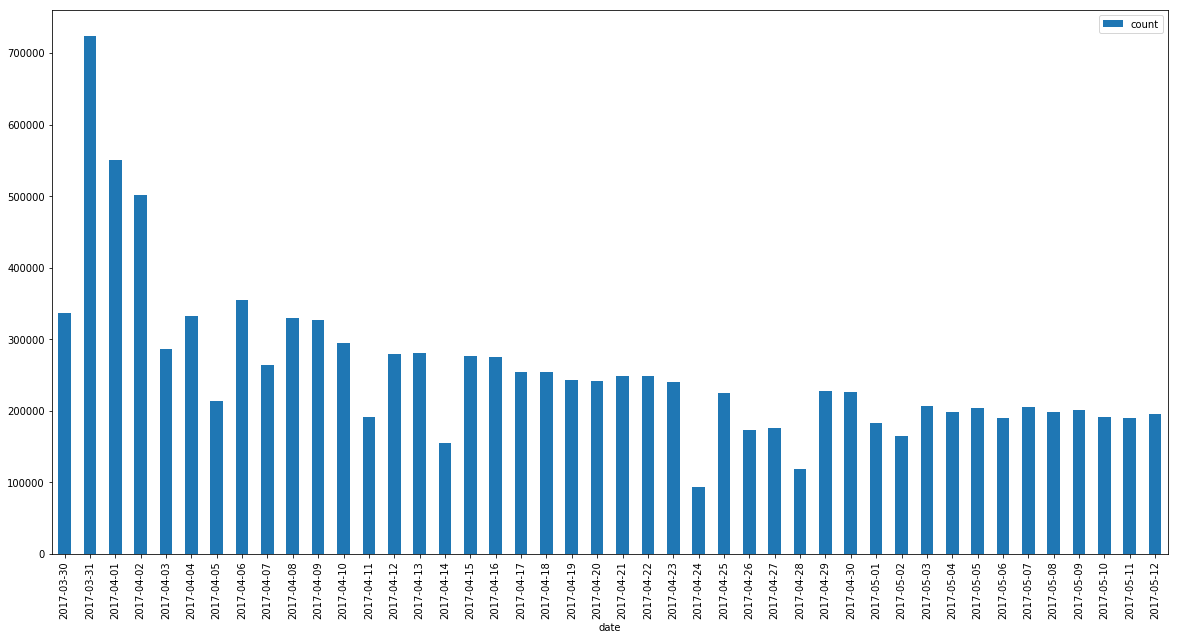

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
date_count.set_index('date').sort_values(by='date', ascending=True).plot.bar(ax=ax)
plt.show()

## 3. Define labels

The date is starting form 2017/3/30 to 2017/5/12. Total 44 days. Use the first 30 days as feature. and the last 14 days as labels.
* Feature window: 2017/3/30 ~ 2017/4/28
* Label window: 2017/4/29 ~ 2017/5/12

In [18]:
import datetime
from dateutil import parser

label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window: ', label_window_start_date, '~', label_window_end_date, ' days:', label_window_size)

label window:  2017-04-29 ~ 2017-05-12  days: 14


In [19]:
feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date - datetime.timedelta(feature_window_size - 1)
print('Feature window: ', feature_window_start_date, '~', feature_window_end_date, ' days:', feature_window_size)

Feature window:  2017-03-30 ~ 2017-04-28  days: 30


Select unique `uid` in feature window (2017/3/30 ~ 2017/4/28).

In [20]:
df_model_uid = df.filter((F.col('date') >= feature_window_start_date) & 
                         (F.col('date') <= feature_window_end_date)).select('uid').distinct()

In [21]:
df_model_uid.show(5)

+---------+
|      uid|
+---------+
|168320671|
|168129526|
|168411726|
|168412583|
|168437862|
+---------+
only showing top 5 rows



In [22]:
df_model_uid.count()

50230

There are 51,637 users in 2017/3/30 to 2017/5/12 time window. And only 50,230 users in 2017/3/30 to 2017/4/28 feature window.

#### Set active user labels

Define active users if they are activate in label window (2017/4/29 ~ 2017/5/12).
* Active label = 0
* Churn label = 1

In [23]:
df_active_uid_in_label_window = df.filter((F.col('date') >= label_window_start_date) & 
                                          (F.col('date') <= label_window_end_date))\
                                  .select('uid').distinct().withColumn('label', F.lit(0))

In [24]:
df_label = df_model_uid.join(df_active_uid_in_label_window, on='uid', how='left')
df_label = df_label.fillna(1)

In [25]:
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|28492|
|    0|21738|
+-----+-----+



In [26]:
df_label.show()

+---------+-----+
|      uid|label|
+---------+-----+
| 11596711|    0|
|165827786|    1|
|167328646|    1|
|167569919|    1|
|167570402|    0|
|167571223|    0|
|167571405|    0|
|167571423|    0|
|167574952|    1|
|167575253|    0|
|167577670|    0|
|167586714|    1|
|167599280|    1|
|167614777|    1|
|167618975|    1|
|167640944|    0|
|167650198|    0|
|167651907|    1|
|167654524|    0|
|167659420|    0|
+---------+-----+
only showing top 20 rows



In [27]:
df_label.count()

50230

In [28]:
df_label.distinct().count()

50230

## 4. Feature generation

### Events in feature window

Feature window: 2017/3/30 ~ 2017/4/28

In [29]:
df_feature_window = df.filter((F.col('date') >= feature_window_start_date) & 
                              (F.col('date') <= feature_window_end_date))

### Frequency features

#### Method1

#### Define function to generate frequency features

In [30]:
def frequency_feature_generation(df, event, time_window, snapshot_date):
    '''
    Generate frequency features for one event type and one time window
    '''
    df_feature = df.filter(F.col('event') == event)\
                   .filter((F.col('date') >= snapshot_date - datetime.timedelta(time_window - 1)) &
                           (F.col('date') <= snapshot_date))\
                   .groupBy('uid').agg(F.count(F.col('uid')).alias('freq_' + event + '_last_' + str(time_window)))
    return df_feature

#### Generate one feature

Select `uid` in 2017/4/19 ~ 2017/4/28 with `event='S'` and count.

In [31]:
event = 'S'
time_window = 10
snapshot_date = feature_window_end_date

df_feature = frequency_feature_generation(df_feature_window, event, time_window, snapshot_date)

In [32]:
df_feature.show(5)

+---------+--------------+
|      uid|freq_S_last_10|
+---------+--------------+
|168703618|            20|
|168903441|            12|
| 59179355|             7|
|168872733|             2|
| 11596711|            11|
+---------+--------------+
only showing top 5 rows



This table counts the searching times for each user in the last 10 days of feature window (2017/4/19 to 2017/4/28).

#### Generate frequency features

Select `uid` and count.

|Time window | Date       |
|-----------:|-----------:|
|      1 day |        4/28|
|     3 days | 4/26 ~ 4/28|
|     7 days | 4/22 ~ 4/28|
|    14 days | 4/15 ~ 4/28|
|    30 days | 3/30 ~ 4/28|

In [33]:
event_list = ['P', 'S', 'D']
time_window_list = [1, 3, 7, 14, 30]
df_feature_list = []

for event in event_list:
    for time_window in time_window_list:
        df_feature_list.append(frequency_feature_generation(df_feature_window, event, time_window, snapshot_date))

In [34]:
df_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint],
 DataFrame[uid: string, freq_P_last_3: bigint],
 DataFrame[uid: string, freq_P_last_7: bigint],
 DataFrame[uid: string, freq_P_last_14: bigint],
 DataFrame[uid: string, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint],
 DataFrame[uid: string, freq_S_last_3: bigint],
 DataFrame[uid: string, freq_S_last_7: bigint],
 DataFrame[uid: string, freq_S_last_14: bigint],
 DataFrame[uid: string, freq_S_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint],
 DataFrame[uid: string, freq_D_last_3: bigint],
 DataFrame[uid: string, freq_D_last_7: bigint],
 DataFrame[uid: string, freq_D_last_14: bigint],
 DataFrame[uid: string, freq_D_last_30: bigint]]

In [35]:
for feature_list in df_feature_list:
    feature_list.show(5)
    print('\n')

+---------+-------------+
|      uid|freq_P_last_1|
+---------+-------------+
|168225678|            6|
|168373237|            7|
|168477183|           54|
|168129526|           16|
|168215121|           63|
+---------+-------------+
only showing top 5 rows



+---------+-------------+
|      uid|freq_P_last_3|
+---------+-------------+
|168703618|           99|
| 11596711|           17|
|168796267|           26|
|169151926|           68|
|168744871|           32|
+---------+-------------+
only showing top 5 rows



+---------+-------------+
|      uid|freq_P_last_7|
+---------+-------------+
|168703618|          294|
| 11596711|           36|
|168796267|           65|
|169151926|          149|
|168744871|           62|
+---------+-------------+
only showing top 5 rows



+---------+--------------+
|      uid|freq_P_last_14|
+---------+--------------+
|168703618|           612|
| 11596711|            71|
|168796267|            71|
|169151926|           296|
|168744871|           121|
+

Using `frequency_feature_generation()`, I got 15 tables. However, I would like to have a single table instead of 15 separated tables. The Method 2 can get 3 single tables, one for each event.

#### Method 2

Use `when().otherwise()`

`*[]` opens list and makes them comma separated

In [36]:
def frequency_feature_generation_time_window(df, event, time_window_list, snapshot_date):
    '''
    Generate frequency features for one event type and a list of time window
    '''
    df_feature = df.filter(F.col('event') == event)\
                   .groupBy('uid')\
                   .agg(*[F.sum(F.when(
                                        (F.col('date') >= snapshot_date - datetime.timedelta(time_window - 1)) &
                                        (F.col('date') < snapshot_date)
                                   , 1).otherwise(0)\
                               ).alias('freq_' + event + '_last_' + str(time_window)) \
                          for time_window in time_window_list])
    return df_feature

#### Generate one event type for all time window

In [37]:
event = 'S'
time_window_list = [1, 3, 7, 14, 30]
snapshot_date = feature_window_end_date

df_feature = frequency_feature_generation_time_window(df_feature_window, event, time_window_list, snapshot_date)
df_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|168310858|            0|            1|            1|             5|            16|
|168314164|            0|            0|            3|            20|            55|
|168275145|            0|            0|            9|            19|            53|
|168479610|            0|            0|           11|            13|            71|
|168703618|            0|            4|           15|            21|            60|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



#### Generate frequency features for all event_list and time_window_list

In [38]:
event_list = ['P', 'S', 'D']
time_window_list = [1, 3, 7, 14, 30]
df_feature_list = []

for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_window(df_feature_window, 
                                                                    event, 
                                                                    time_window_list, 
                                                                    snapshot_date))

In [39]:
df_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint]]

In [40]:
for feature_list in df_feature_list:
    feature_list.show(5)
    print('\n')

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|168320671|            0|           16|           46|           170|           294|
|168129526|            0|            5|           49|           139|           675|
|168411726|            0|            0|            0|             0|            39|
|168412583|            0|           12|           54|            84|           177|
|168437862|            0|          115|          211|           220|           417|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+----------

### Recency features

Find the last date of each user for each event. And count the number of days from last event date to 2017/4/28.

In [41]:
# defined as days from last event
# can generate one feature for each type of event

def days_from_last_event(df, event, snapshot_date):
    # 一行就解決，不好懂
#     df_days_from_last_event = df.filter(F.col('event') == event)\
#                                 .groupBy('uid')\
#                                 .agg(F.datediff(F.lit(snapshot_date), F.max('date')).alias('days_from_last_evnet'))
    # 拆成下面兩行
    # 先找出該 user 在 event 的最後一天
    df_days_from_last_event = df.filter(F.col('event') == event)\
                                .groupBy('uid').agg(F.max('date').alias('last_date'))
    # 再和 2017/4/28 比，看差幾天
    df_days_from_last_event = df_days_from_last_event.withColumn('days_from_last_' + event + '_evnet', 
                                                                 F.datediff(F.lit(snapshot_date), F.col('last_date')))\
                                                     .select('uid', 'days_from_last_' + event + '_evnet')
    return df_days_from_last_event

In [42]:
event_list = ['P', 'S', 'D']
snapshot_date = feature_window_end_date
df_days_list = []

for event in event_list:
    df_days_list.append(days_from_last_event(df_feature_window, event, snapshot_date))
    
for df_days in df_days_list:
    df_days.show()
    print('\n')

+---------+----------------------+
|      uid|days_from_last_P_evnet|
+---------+----------------------+
|168320671|                     1|
|168129526|                     0|
|168411726|                    18|
|168412583|                     0|
|168437862|                     0|
|168477183|                     0|
|168479610|                     0|
|168306664|                     0|
|168478957|                     1|
|168101854|                     0|
|168515885|                     0|
|168340102|                     0|
|168310858|                     0|
|168107903|                     2|
|168225678|                     0|
|168372226|                     0|
|168081728|                    15|
|168083706|                    15|
|168120418|                     1|
|168076605|                    11|
+---------+----------------------+
only showing top 20 rows



+---------+----------------------+
|      uid|days_from_last_S_evnet|
+---------+----------------------+
|168310858|                

### Profile features

In [43]:
df_play = spark.read.csv('data/play.csv', header=True)

In [44]:
df_play.show()

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168261396|    ar| 5841437|2017-04-10|      199|        199|
|168478408|    ar|23534985|2017-04-10|      311|        311|
|168064721|    ip|  853270|2017-04-10|      318|        318|
|168411174|    ar|23562956|2017-04-10|      275|        275|
|168503909|    ar|  294786|2017-04-10|      180|        180|
|168066213|    ar| 6329735|2017-04-10|      289|        289|
|168483420|    ar|       0|2017-04-10|      277|        277|
|168064721|    ip|  853270|2017-04-10|       16|        318|
|168374657|    ar|20674550|2017-04-10|      276|        276|
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168282577|    ar|  466825|2017-04-10|      195|        248|
|168156044|    ar| 3373247|2017-04-10|      227|        227|
|168074544|    ip| 31944

In [45]:
df_play.select('uid').distinct().count()

51635

There are 51635 users in the entire period.

In [46]:
df_play_feature_window = df_play.filter((F.col('date') >= feature_window_start_date) &
                                        (F.col('date') <= feature_window_end_date))
df_profile_tmp = df_play_feature_window.select('uid', 'device').distinct()

In [47]:
df_play_feature_window.select('uid').distinct().count()

49856

There are 49,856 out ouf 51,635 users in the feature window.

In [48]:
df_profile_tmp.show(5)

+---------+------+
|      uid|device|
+---------+------+
|168356695|    ip|
|168331916|    ar|
|168369187|    ar|
|168470397|    ar|
|168347733|    ar|
+---------+------+
only showing top 5 rows



In [49]:
df_profile_tmp.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    mc|    2|
|    ar|42997|
|    wp|    2|
|    ip| 6865|
+------+-----+



In [50]:
# check if one user has two devices
df_profile_tmp.count()

49866

In [51]:
df_profile_tmp.distinct().count()

49866

There are 49,856 distince users but there are 49,866 rows. So 10 users have two devices.

Now divide users in two groups, iPhone user and non-iPhone user
* iPhone user: `device_type=1`
* Non-iPhone user: `device_type=2`

In [52]:
df_profile_tmp = df_profile_tmp.withColumn('device_type', F.when(F.col('device') == 'ip', 1).otherwise(2))
df_profile_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 6865|
|          2|43001|
+-----------+-----+



In [53]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid', 'device_type'), on='uid', how='left')
df_profile.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|       null|  374|
|          1| 6865|
|          2|43001|
+-----------+-----+



In [54]:
df_profile.show()

+---------+-----------+
|      uid|device_type|
+---------+-----------+
| 11596711|          2|
|165827786|          2|
|167328646|          2|
|167569919|          2|
|167570402|          2|
|167571223|          2|
|167571405|          2|
|167571423|          2|
|167574952|          2|
|167575253|          2|
|167577670|          2|
|167586714|          2|
|167599280|          2|
|167614777|          2|
|167618975|          2|
|167640944|          2|
|167650198|          1|
|167651907|          2|
|167654524|          2|
|167659420|          1|
+---------+-----------+
only showing top 20 rows



In [55]:
df_profile.count()

50240

There are only 50,230 users in `df_label`. However, there are 10 users having two devices so there are 50,240 rows in `df_profile`.

### Total play time features

In [56]:
# Can you generate total song play time features (using play_ds data) for different time window
# using play data (need to clean play time first, play time may be negative in data)

# Convert play_time and strong_length from string to integer
df_play = df_play.withColumn('play_time', F.col('play_time').cast('integer'))
df_play = df_play.withColumn('song_length', F.col('song_length').cast('integer'))
df_play

DataFrame[uid: string, device: string, song_id: string, date: string, play_time: int, song_length: int]

In [57]:
df_play.show()

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168261396|    ar| 5841437|2017-04-10|      199|        199|
|168478408|    ar|23534985|2017-04-10|      311|        311|
|168064721|    ip|  853270|2017-04-10|      318|        318|
|168411174|    ar|23562956|2017-04-10|      275|        275|
|168503909|    ar|  294786|2017-04-10|      180|        180|
|168066213|    ar| 6329735|2017-04-10|      289|        289|
|168483420|    ar|       0|2017-04-10|      277|        277|
|168064721|    ip|  853270|2017-04-10|       16|        318|
|168374657|    ar|20674550|2017-04-10|      276|        276|
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168282577|    ar|  466825|2017-04-10|      195|        248|
|168156044|    ar| 3373247|2017-04-10|      227|        227|
|168074544|    ip| 31944

Only select those `play_time` > 0 and `song_length` > 0

In [58]:
df_play_new = df_play.filter((F.col('play_time') > 0) & (F.col('song_length') > 0))

In [59]:
df_play_new.summary().show()

+-------+-------------------+-------+--------------------+----------+------------------+------------------+
|summary|                uid| device|             song_id|      date|         play_time|       song_length|
+-------+-------------------+-------+--------------------+----------+------------------+------------------+
|  count|            7688596|7688596|             7685968|   7688596|           7688596|           7688596|
|   mean| 1.66556569833194E8|   null|1.545768570545177E14|      null| 1448.893665371415| 274.6865209200744|
| stddev|1.420317570545654E7|   null|4.165680824767521...|      null|133027.34809006288|22061.103920138794|
|    min|          100223381|     ar|                  -1|2017-03-30|                 1|                 1|
|    25%|       1.67964203E8|   null|            571668.0|      null|                58|               208|
|    50%|       1.68339183E8|   null|           4246355.0|      null|               202|               244|
|    75%|       1.68696669E8

In [60]:
# df_play_new.agg({'play_time':'max'}).collect()[0]

In [61]:
# df_play_new.agg({'play_time':'min'}).collect()[0]

In [62]:
# df_play_new.agg({'song_length':'max'}).collect()[0]

In [63]:
# df_play_new.agg({'song_length':'min'}).collect()[0]

Need to remove the outlier in `play_time` and `song_length`. The outliers are defined as > mean + 3$\sigma$.

In [64]:
# df_play_new.select(F.mean('play_time'), F.mean('song_length'), F.stddev('play_time'), F.stddev('song_length')).show()

`play_time_mean = df_play_new.agg({'play_time': 'mean'}).collect()[0]` returns `Row(avg(play_time)=1448.893665371415`.

However, I only want to get the value. So I need to add `asDict()` to convert row to dictionary. 
Then I can access the value using key.

`play_time_mean = df_play_new.agg({'play_time': 'mean'}).collect()[0].asDict()` returns `{'avg(play_time)': 1448.893665371415}`

In [65]:
play_time_mean = df_play_new.agg({'play_time': 'mean'}).collect()[0].asDict()
play_time_std = df_play_new.agg({'play_time': 'stddev'}).collect()[0].asDict()
song_length_mean = df_play_new.agg({'song_length': 'mean'}).collect()[0].asDict()
song_length_std = df_play_new.agg({'song_length': 'stddev'}).collect()[0].asDict()

In [66]:
# print(type(play_time_mean))
# print(play_time_mean, play_time_std, song_length_mean, song_length_std)

In [67]:
df_play_outliers_removed = df_play_new.filter((F.col('play_time') <= play_time_mean['avg(play_time)'] + 3 * play_time_std['stddev(play_time)']) &
                                              (F.col('song_length') <= song_length_mean['avg(song_length)'] + 3 * song_length_std['stddev(song_length)']))

In [68]:
df_play_outliers_removed.count()

7688230

In [69]:
df_play_outliers_removed.summary().show()

+-------+--------------------+-------+--------------------+----------+------------------+-----------------+
|summary|                 uid| device|             song_id|      date|         play_time|      song_length|
+-------+--------------------+-------+--------------------+----------+------------------+-----------------+
|  count|             7688230|7688230|             7685602|   7688230|           7688230|          7688230|
|   mean| 1.665570110513845E8|   null|1.545842182391503...|      null|1255.5882706422674|266.7060863163563|
| stddev|1.4202064230798164E7|   null|4.165780010259676E16|      null|16175.510109621717|293.1677978355522|
|    min|           100223381|     ar|                  -1|2017-03-30|                 1|                1|
|    25%|        1.67964203E8|   null|            571232.0|      null|                58|              208|
|    50%|        1.68339183E8|   null|           4246298.0|      null|               202|              244|
|    75%|        1.68696817E

In [70]:
df_play_outliers_removed.show()

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168261396|    ar| 5841437|2017-04-10|      199|        199|
|168478408|    ar|23534985|2017-04-10|      311|        311|
|168064721|    ip|  853270|2017-04-10|      318|        318|
|168411174|    ar|23562956|2017-04-10|      275|        275|
|168503909|    ar|  294786|2017-04-10|      180|        180|
|168066213|    ar| 6329735|2017-04-10|      289|        289|
|168483420|    ar|       0|2017-04-10|      277|        277|
|168064721|    ip|  853270|2017-04-10|       16|        318|
|168374657|    ar|20674550|2017-04-10|      276|        276|
|168408359|    ip| 5638883|2017-04-10|       24|         24|
|168282577|    ar|  466825|2017-04-10|      195|        248|
|168156044|    ar| 3373247|2017-04-10|      227|        227|
|168074544|    ip| 31944

#### Generate total play time features for all event_list and time_window_list

In [71]:
def total_play_time_generation_time_window(df, time_window_list, snapshot_date):
    '''
    Generate frequency features for one event type and a list of time window
    '''
    df_feature = df.groupBy('uid')\
                   .agg(*[F.sum(F.when(
                                        (F.col('date') >= snapshot_date - datetime.timedelta(time_window - 1)) &
                                        (F.col('date') < snapshot_date)
                                   , F.col('play_time')).otherwise(0)\
                               ).alias('total_play_time_' + str(time_window)) \
                          for time_window in time_window_list])
                   
    return df_feature

In [72]:
time_window_list = [1, 3, 7, 14, 30]
snapshot_date = feature_window_end_date

df_total_play_time = total_play_time_generation_time_window(df_play_outliers_removed, time_window_list, snapshot_date)

In [73]:
df_total_play_time.show(5)

+---------+-----------------+-----------------+-----------------+------------------+------------------+
|      uid|total_play_time_1|total_play_time_3|total_play_time_7|total_play_time_14|total_play_time_30|
+---------+-----------------+-----------------+-----------------+------------------+------------------+
|168129526|                0|                0|             3447|             15174|             99166|
|168411726|                0|                0|                0|                 0|              1325|
|168412583|                0|             1594|             6445|             11609|             20942|
|168437862|                0|            24419|            42203|             44142|             81670|
|168477183|                0|            12697|            15916|             69830|            199381|
+---------+-----------------+-----------------+-----------------+------------------+------------------+
only showing top 5 rows



### Fancier frequency features

The units of `play_time` and `song_length` are in second. So $\frac{play\_time}{song\_length} > 0.8$ stands for the songs play 80% of their length. However, the type of `play_time` and `song_length` are integer. I need to use `play_time` > 0.8 * `song_length` instead.

In [74]:
# Can you generate counts of songs play 80% of their song length (using play_ds data) for different time window
# using play data (need to clean play time and song length first, play time may be negative in data, song length may be zeros)

In [75]:
df_play_eighty = df_play_outliers_removed.withColumn('eighty', F.when(F.col('play_time') > 0.8 * F.col('song_length'), 1).otherwise(0))
df_play_eighty = df_play_eighty.select('uid', 'date', 'eighty')

In [76]:
df_play_eighty.show()

+---------+----------+------+
|      uid|      date|eighty|
+---------+----------+------+
|168408359|2017-04-10|     1|
|168261396|2017-04-10|     1|
|168478408|2017-04-10|     1|
|168064721|2017-04-10|     1|
|168411174|2017-04-10|     1|
|168503909|2017-04-10|     1|
|168066213|2017-04-10|     1|
|168483420|2017-04-10|     1|
|168064721|2017-04-10|     0|
|168374657|2017-04-10|     1|
|168408359|2017-04-10|     1|
|168282577|2017-04-10|     0|
|168156044|2017-04-10|     1|
|168074544|2017-04-10|     1|
|168441911|2017-04-10|     1|
|168523596|2017-04-10|     1|
|168479778|2017-04-10|     1|
|168412268|2017-04-10|     1|
|168427662|2017-04-10|     0|
|168262028|2017-04-10|     1|
+---------+----------+------+
only showing top 20 rows



Generate total `play_time` / `song_length` > 0.8 features for all event_list and time_window_list

In [77]:
def eighty_generation_time_window(df, time_window_list, snapshot_date):
    '''
    Generate frequency features for one event type and a list of time window
    '''
    df_feature = df.groupBy('uid')\
                   .agg(*[F.sum(F.when((F.col('date') >= snapshot_date - datetime.timedelta(time_window - 1)) &
                                       (F.col('date') < snapshot_date),
                                       F.when(F.col('play_time') > 0.8 * F.col('song_length'), 1).otherwise(0)\
                                      ).otherwise(0)\
                               ).alias('eighty_' + str(time_window)) \
                          for time_window in time_window_list])
    return df_feature

In [78]:
time_window_list = [1, 3, 7, 14, 30]
snapshot_date = feature_window_end_date

df_eighty = eighty_generation_time_window(df_play_outliers_removed, time_window_list, snapshot_date)

In [79]:
df_eighty.show()

+---------+--------+--------+--------+---------+---------+
|      uid|eighty_1|eighty_3|eighty_7|eighty_14|eighty_30|
+---------+--------+--------+--------+---------+---------+
|168129526|       0|       0|       9|       48|      222|
|168411726|       0|       0|       0|        0|        5|
|168412583|       0|       3|      14|       36|       64|
|168437862|       0|      83|     164|      172|      321|
|168477183|       0|      41|      50|      226|      705|
|168479610|       0|      39|      67|      140|      255|
|168320671|       0|       0|       0|       16|       35|
|168306664|       0|       0|       5|       72|      255|
|168478957|       0|      30|      30|      105|      140|
|168515885|       0|       0|      11|       50|      123|
|168101854|       0|       0|       0|        3|       23|
|168340102|       0|      14|      14|       51|      130|
|168310858|       0|       4|       4|       29|       47|
|168107903|       0|       6|       6|        6|       6

## 5. Form training data

In [80]:
def join_feature_data(df_master, df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature, on='uid', how='left')
        #df_master.persist() # uncomment if number of joins is too many
        
    return df_master

#### Join all behavior features

In [81]:
df_model_final = join_feature_data(df_label, df_feature_list)

#### Join all profile features

In [82]:
df_model_final = join_feature_data(df_model_final, [df_profile])

#### Join recency, total play time, and fancier frequency features

In [83]:
df_model_final = join_feature_data(df_model_final, df_days_list)

In [84]:
df_model_final = join_feature_data(df_model_final, [df_total_play_time, df_eighty])

In [85]:
# df_model_final.schema.names

In [86]:
# df_model_final.printSchema()

In [87]:
df_model_final.fillna(0).toPandas().to_csv('data/model_final.csv', index=False)